# Albedo algorithm 
To calculate albedo for Landsat 8 data, you'll need Landsat bands 1-5. The steps are as follows: 

## 1) Go from raster data, saved as Digital Numbers, to top of the atmosphere (TOA) reflectance:

$$ \rho*\lambda = \text{reflectance mult band}*DN +\text{reflectance add band } $$
where  
$\text{reflectance mult band} =2.000\times 10^{-5} $ 


$ \text{reflectance add band } = -0.100000 $

## 2) Go from reflectance to albedo using Ron Smith's normalized Liang et. al. algorithm:

$$ \alpha = \frac{(0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018) }{1.016} $$

In Python, this is implemented as : 


In [1]:
# import libraries
import gdal
import numpy as np

In [2]:
# pre-allocate raster size by reading in band 1 of the landsat image
i = 1
path = 'data/BaltimoreLandsatSummer2015/L8 OLI_TIRS/LC80150332015229LGN00/'
file = path+ 'LC80150332015229LGN00_B'+'%s'%i +'.TIF'
layer = gdal.Open(file) # Open file
src = layer.GetRasterBand(1) 
DN = src.ReadAsArray() # Read in raster data as a numpy array

# pre-allocate bands
B = np.zeros([5,DN.shape[0], DN.shape[1]]) 

# Get bands 1-5 and convert to reflectances
for i in (1,2,3,4,5): 
    #O pen the file (redundant for the 1st band)
    file = path+ 'LC80150332015229LGN00_B'+'%s'%i +'.TIF'
    layer = gdal.Open(file)
    src = layer.GetRasterBand(1)
    
    # read in the digital number
    DN = src.ReadAsArray() 
    
    # convert from digital number to toa reflectance  using : rho*\lambda = REFLECTANCE_MULT_BAND_x*DN +REFLECTANCE_ADD_BAND_x
    reflectance_mult_band = 2.000e-5
    reflectance_add_band  = -0.100000
    B[i-1,:, :] = reflectance_mult_band*DN+reflectance_add_band

# calculate albedo using ((0.356*B1) + (0.130*B2) + (0.373*B3) + (0.085*B4) + (0.072*B5) -0.018) )/(1.016)
alb = ((0.356*B[0,:]) + (0.130*B[1,:]) + (0.373*B[2,:]) + (0.085*B[3,:]) + (0.072*B[4,:]) -0.018)/1.016

# Albedo is between zero and 1, mask possible errors as NaNs
alb[alb>1] = 'NaN'
alb[alb<0] = 'NaN'

In [3]:
# Save out file :
# define driver
format = "GTiff"
driver = gdal.GetDriverByName( format )

# copy over the metadata from the last file so projection info is the same
src_ds = gdal.Open( file )
dst_ds = driver.CreateCopy('LC80150332015229LGN00Albedo.TIF', src_ds, 0 )

# write the albedo data
dst_ds.GetRasterBand(1).WriteArray( alb )
# save
dst_ds.GetRasterBand(1).FlushCache()

# close the datasets
dst_ds = None
src_ds = None

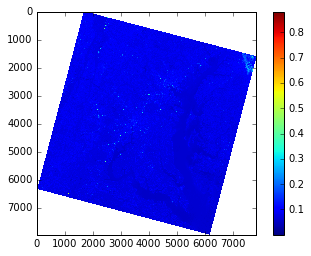

In [5]:
# see the albedo
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(alb)
plt.colorbar()

In [ ]:
# check data 
ds = gdal.Open('LC80150332015229LGN00Albedo.TIF')
src = ds.GetRasterBand(1)
DN = src.ReadAsArray() 

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(DN)
plt.colorbar()